# Estimating the frequency of a sine wave

In this notebook I will use a simple MLP to estimate the frequency of sine waves

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, LSTM, Flatten
from keras.optimizers import SGD
from matplotlib import pyplot as plt

Using TensorFlow backend.


### Global parameters

In [2]:
# data params
max_freq = 10.
Nsamples = 200 # sampling frequency above niquist
Nsignals = 10000
# network params
epochs = 20
batch_size = 64

In [3]:
def gen_sine(frequency, phase):
    "Generate a sinusoidal signal with a given frequeny and phase shift"
    return np.sin(frequency * np.linspace(phase, phase + 2. * np.pi, Nsamples))

### Make data

The "labels" will be the parameters used to generate the signals and the data will be the signals.

In [4]:
Y = np.array([np.random.uniform(0.1,max_freq,Nsignals),np.random.uniform(0,1,Nsignals)]).T

In [5]:
# loop through parameters and generate sine waves
X = np.array([gen_sine(y[0], y[1]) for y in Y])

### Check data

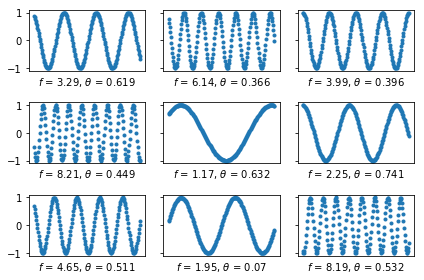

In [6]:
fig, axs = plt.subplots(3,3, sharex = True, sharey = True)
axs = axs.ravel()
for i in range(len(axs)):
    axs[i].plot(X[i], '.')
    axs[i].set_xticks([])
    axs[i].set_xlabel(r'$f$ = {0:.3}, $\theta$ = {1:.3}'.format(Y[i,0], Y[i,1]))
plt.tight_layout()

### Split data
Take a portion of the data to use as unseen test data

In [7]:
# get a random set of indices
train_idx = np.random.randint(X.shape[0], size=int(0.9*X.shape[0]))
test_idx = np.random.randint(X.shape[0], size=int(0.1*X.shape[0]))

In [8]:
# split the data
x_train, x_test = X[train_idx,:], X[test_idx,:]
y_train, y_test = Y[train_idx,:], Y[test_idx,:]

## The Model
Use a simple MLP

In [9]:
model = Sequential()
model.add(Dense(100,input_shape = (Nsamples,), activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(100, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(2, activation = 'linear'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 202       
Total params: 30,402
Trainable params: 30,402
Non-trainable params: 0
_________________________________________________________________


### Compile
The loss function used in mean squared error, since we are trying to minimize the difference between the predicted values  and the true values

In [10]:
model.compile(loss='mean_squared_error',
              optimizer=SGD(lr = 0.001, momentum = 0.9, nesterov = True))

### Training

In [11]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score)

Train on 8100 samples, validate on 900 samples
Epoch 1/20
8100/8100 [==============================] - 1s 119us/step - loss: 1.8455 - val_loss: 0.0885
Epoch 2/20
8100/8100 [==============================] - 1s 64us/step - loss: 0.2880 - val_loss: 0.0670
Epoch 3/20
8100/8100 [==============================] - 1s 66us/step - loss: 0.2527 - val_loss: 0.0612
Epoch 4/20
8100/8100 [==============================] - 0s 60us/step - loss: 0.2364 - val_loss: 0.0472
Epoch 5/20
8100/8100 [==============================] - 1s 67us/step - loss: 0.2192 - val_loss: 0.0422
Epoch 6/20
8100/8100 [==============================] - 1s 73us/step - loss: 0.2009 - val_loss: 0.0491
Epoch 7/20
8100/8100 [==============================] - 1s 73us/step - loss: 0.1911 - val_loss: 0.0422
Epoch 8/20
8100/8100 [==============================] - 1s 71us/step - loss: 0.1775 - val_loss: 0.0411
Epoch 9/20
8100/8100 [==============================] - 1s 67us/step - loss: 0.1782 - val_loss: 0.0355
Epoch 10/20
8100/8100 [==

### Predictions

In [12]:
# easily retrieve the predictions
y_preds = model.predict(x_test)

If the predictions are exactly the true value we would expect a straight line. We actually see a line with some spread, the more spread the less accurate the predictions.

In this case the periodic nature of the sine wave makes estimating the phase shift $\theta$ hard, but the frequency $f$ is easy enough.

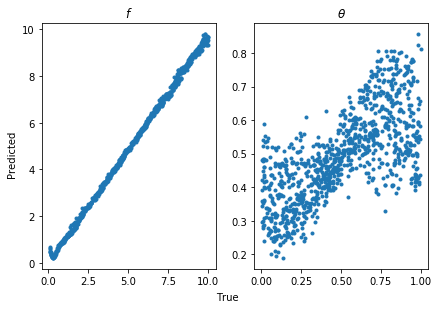

In [13]:
fig, axs = plt.subplots(1,2)
axs = axs.ravel()
for i in range(len(axs)):
    axs[i].plot(y_test[:,i], y_preds[:,i], '.')
plt.tight_layout()
axs[0].set_title(r'$f$')
axs[1].set_title(r'$\theta$')
fig.text(0.5, -0.01, 'True', ha='center')
fig.text(-0.01, 0.5, 'Predicted', va='center', rotation='vertical')
plt.show()